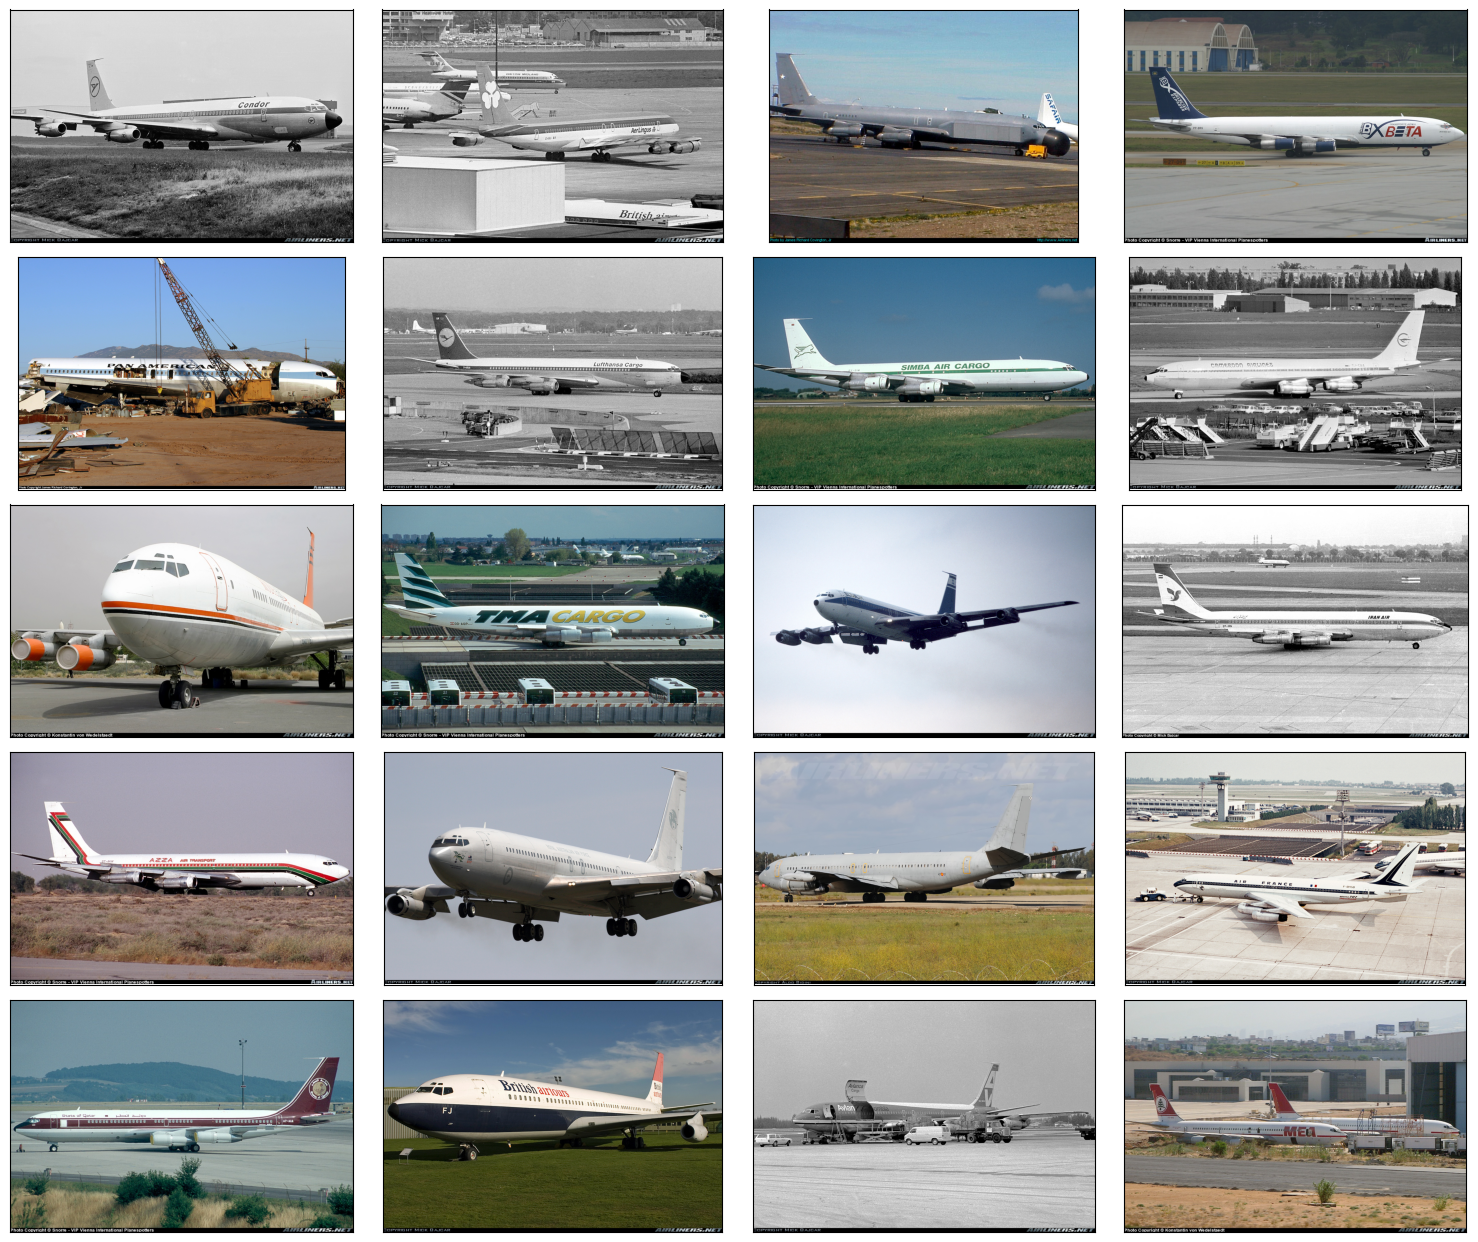

In [1]:
import torch 
import torchvision
import matplotlib.pyplot as plt
import os

def show_images(dataset, num_samples = 20, cols = 4, save_name = None):
    plt.figure(figsize=(15, 15))
    for i , img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img[0])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    if save_name:
        os.makedirs("images", exist_ok=True)
        path = os.path.join("images", save_name)
        plt.savefig(path)
    plt.show()

data = torchvision.datasets.FGVCAircraft('./data', download=True)
show_images(data, 20, 4, save_name = "aircrafts.png")

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_Size = 128
Batch_size = 128

def load_transformed_dataset():
    data_transform = transforms.Compose([
        transforms.Resize((IMG_Size, IMG_Size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # transforms to between 0 and 1
        transforms.Lambda(lambda x: x * 2 - 1) # transforms to between -1 and 1
    ])
    
    train = torchvision.datasets.FGVCAircraft('./data', split='train', download=True, transform=data_transform)
    
    test = torchvision.datasets.FGVCAircraft('./data', split='test', download=True, transform=data_transform)
    
    return torch.utils.data.ConcatDataset([train, test])
    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda x: (x + 1) / 2), # 0 to 1
        transforms.Lambda(lambda x: x.permute(1, 2, 0)), # C x H x W to H x W x C
        transforms.Lambda(lambda x: x * 255), # 0 to 255
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8)), # float to uint8
        transforms.ToPILImage()
    ])
    
    # If the image is a batch, take the first image only
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))
    
data = load_transformed_dataset()
data_loader = DataLoader(data, batch_size=Batch_size, shuffle=True)

## Noise Generator and Forward Diffusion Process Explanation

### 1. Linear Beta Scheduler

The `linear_beta_scheduler` function generates a sequence of beta values linearly spaced between `start` and `end` over a given number of timesteps, `T`. These betas, denoted as $\beta_t$, control the variance added at each step of the diffusion process.

### 2. Coefficients Computation

- **Betas** ($\beta_t$): A sequence of values controlling the noise level added at each timestep.
- **Alphas** ($\alpha_t$): Defined as $1 - \beta_t$, representing the retention of the original signal at each timestep.
- **Cumulative Products**:
  - $\alpha_t^{\text{cumprod}} = \prod_{i=1}^{t} \alpha_i$: Cumulative product of alphas up to timestep $t$.
  - $\alpha_{t-1}^{\text{cumprod}} = \prod_{i=1}^{t-1} \alpha_i$: Cumulative product of alphas up to timestep $t-1$.
- **Square Root Coefficients**:
  - $\sqrt{\text{recip}_\alpha} = \sqrt{\frac{1}{\alpha_t}}$: Inverse square root of alphas.
  - $\sqrt{\alpha_t^{\text{cumprod}}} = \sqrt{\alpha_t^{\text{cumprod}}}$: Square root of cumulative product of alphas.
  - $\sqrt{1 - \alpha_t^{\text{cumprod}}} = \sqrt{1 - \alpha_t^{\text{cumprod}}}$: Square root of one minus the cumulative product of alphas.

### 3. Noise Sampling and Forward Diffusion

The function `forward_diffusion_sample` generates a noisy version of the input $x_0$ using the following equations:

**Input:**
- $x_0$: The original data (clean sample).
- $t$: Timestep at which to sample the noise.
- `device`: The device to perform computations on (CPU or GPU).

**Steps:**

1. **Noise Generation**: 
   - $noise \sim \mathcal{N}(0, 1)$: Gaussian noise sampled with the same shape as $x_0$.

2. **Mean and Variance Calculation**:
   - $mean\_coeff = \sqrt{\alpha_t^{\text{cumprod}}}$ and $var\_coeff = \sqrt{1 - \alpha_t^{\text{cumprod}}}$
   - $mean = mean\_coeff \cdot x_0$: Scaled version of the original data.
   - $var = var\_coeff \cdot noise$: Scaled noise.

3. **Noisy Sample Generation**:
   - $x_t = mean + var$: The resulting noisy sample $x_t$ at timestep $t$ is the sum of the scaled original data and the scaled noise.

The process progressively adds noise to the data $x_0$ over $T$ timesteps, each step introducing noise controlled by the betas. The forward diffusion process aims to transform the data into pure noise as $t$ approaches $T$.


In [3]:
import torch.nn.functional as F

def linear_beta_scheduler(timesteps,start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0).to(device)
    mean_coeff = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    var_coeff = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)
    mean = mean_coeff * x_0.to(device)
    var = var_coeff * noise
    return mean + var, noise

T = 200
betas = linear_beta_scheduler(T)

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis = 0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # prepend 1.0 and remove last element
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas)

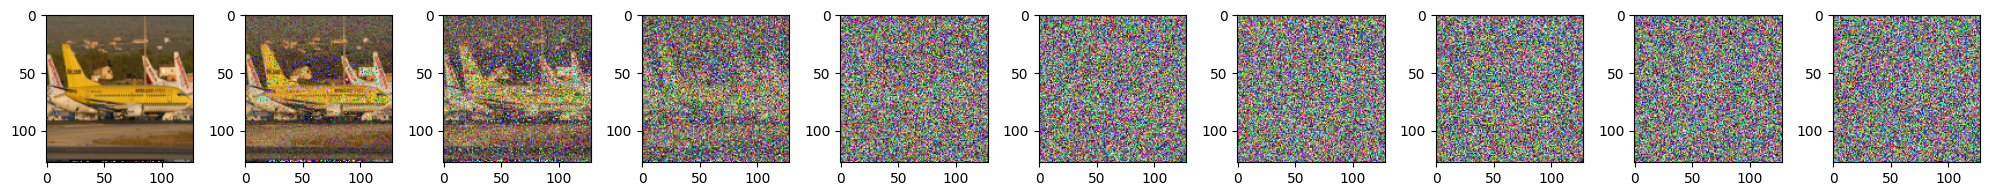

In [4]:
image = next(iter(data_loader))[0]
plt.figure(figsize=(20, 5))
plt.axis = 'off'
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images, idx // stepsize + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)
plt.tight_layout()
plt.savefig("images/forward_diffusion.png")
plt.show()

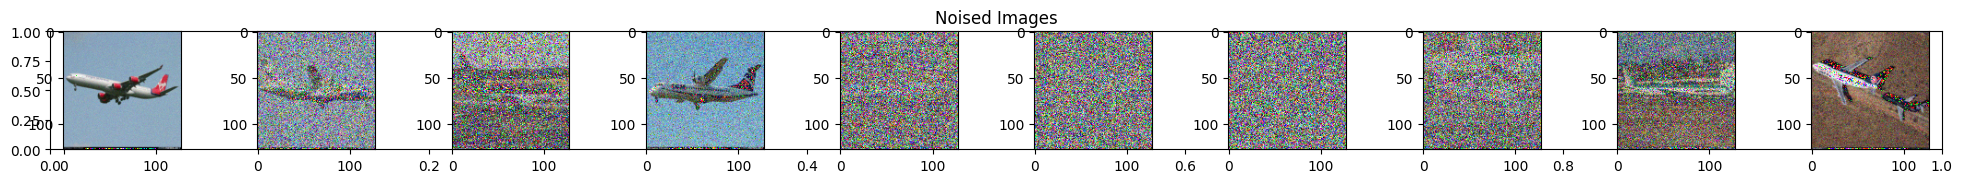

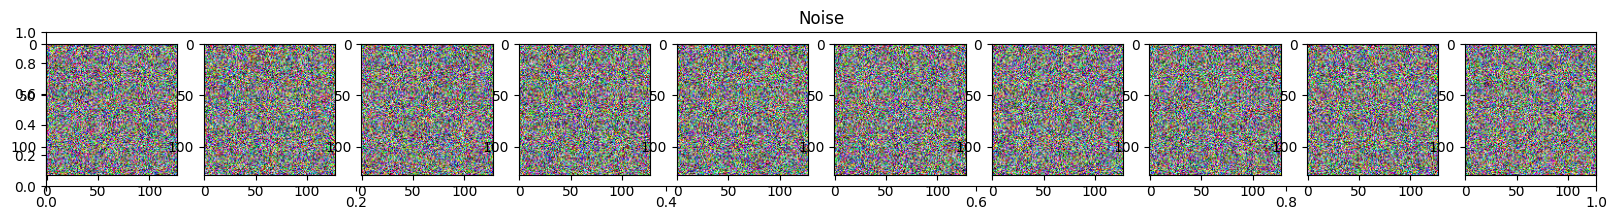

In [5]:
noised_batch, noise = forward_diffusion_sample(next(iter(data_loader))[0], torch.randint(0, T, (Batch_size,)))
plt.figure(figsize=(20, 2))
plt.axis = 'off'
plt.title('Noised Images')
for i in range(10):
    plt.subplot(1, 10, i + 1)
    show_tensor_image(noised_batch[i])
plt.tight_layout()
plt.savefig("images/noised_images.png")
plt.show()
    
plt.figure(figsize=(20, 2))
plt.axis = 'off'
plt.title('Noise')
for i in range(10):
    plt.subplot(1, 10, i + 1)
    show_tensor_image(noise[i])

In [6]:
import torch.nn as nn

def init_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, features, name):
        super(EncoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )
        self.name = name

    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, features, name):
        super(DecoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )
        self.name = name

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = EncoderBlock(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = EncoderBlock(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = EncoderBlock(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = EncoderBlock(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = EncoderBlock(features * 8, features * 16, name="bottleneck")
        
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = DecoderBlock((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = DecoderBlock((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = DecoderBlock((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = DecoderBlock(features * 2, features, name="dec1")
        
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)
        
        self.apply(init_weights)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.conv(dec1)

model = UNet(in_channels=3, out_channels=3)

In [7]:
# # forward_pass 
# with torch.no_grad():
#     output = model(noised_batch)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#     loss = criterion(output, noise)
#     print(loss)

In [11]:
def PSNR(loss):
    return 10 * torch.log10(4.0 / torch.sqrt(loss))

def ssim(img1, img2, window_size=11, window=None, size_average=True):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    if window is None:
        window = create_window(window_size, img1.size(1))
    
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=img1.size(1))
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=img2.size(1))
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=img1.size(1)) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=img2.size(1)) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=img1.size(1)) - mu1_mu2
    
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean([1, 2, 3])

def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        window_size = torch.tensor(window_size)
        gauss = torch.Tensor([torch.exp(-(x - window_size//2)**2/(2*sigma**2)) for x in range(window_size)])
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

In [12]:
from torch.optim.lr_scheduler import LambdaLR
import math

def exponential_decay_lr_scheduler(optimizer, decay_rate, epoch):
    def lr_lambda(epoch):
        return math.exp(-decay_rate * epoch)
    return LambdaLR(optimizer, lr_lambda)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
decay_rate = 0.1
scheduler = exponential_decay_lr_scheduler(optimizer, decay_rate, epoch=0)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for step, (images, _ ) in enumerate(data_loader):
        noisy_images, noise = forward_diffusion_sample(images, torch.randint(0, T, (Batch_size,)), device)
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 10 == 0:
            scheduler.step()
            print(f"Epoch {epoch+1}/{num_epochs}, Step {step}/{len(data_loader)}, lr: {optimizer.param_groups[0]['lr']}")
            model.eval()
            
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(data_loader)}, LR: {lr}")
    
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        noisy_images, noise = forward_diffusion_sample(images, torch.randint(0, T, (Batch_size,)), device)
        outputs = model(noisy_images)
        loss = criterion(outputs, noise)
        psnr = PSNR(loss)
        ssim_val = ssim(outputs, noise)
        print(f"EPOCH {epoch+1}/{num_epochs}, PSNR: {psnr}, SSIM: {ssim_val}")

Epoch 1/1, Step 0/53, lr: 0.0009048374180359595
EPOCH 1/1, PSNR: 4.59473180770874, SSIM: 0.0016266461461782455
EPOCH 1/1, PSNR: 5.7089033126831055, SSIM: 0.0032290304079651833


KeyboardInterrupt: 